In [1]:
import os, time
import numpy as np
import pickle

# Figures 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker
import matplotlib.patches as patches
from style import colors
from fig_specs import *

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV

In [2]:
sce_plt = [3, 1]
# sce_plt = [2, 3, 0, 1]
n_sce_plt = len(sce_plt)

Loaded from  ../../data/oblique/neuro_corr_no_noise.pkl


['Cycling', '3-bit flipflop', 'Mante', 'Romo', 'Complex sine']

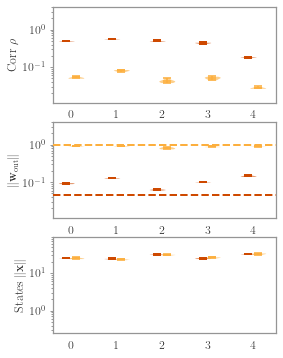

In [3]:
def plot_corr(axes):
    n_rows, n_cols = axes.shape
    
    # Load data
    with_noise = False
    if with_noise:
        file_name = "neuro_corr.pkl"
    else:
        file_name = "neuro_corr_no_noise.pkl"
    data_file = os.path.join(data_path, file_name)
    with open(data_file, 'rb') as handle:
        [
        task_names, task_lbls, n_task, lbl_sce,
        n_samples, n_sce, n_mi, dim_hid, 
        with_noise, loss_sce, n_steps_sce, norm_w_sce, norm_h_sce, corr_w_h_sce, 
        corr2_w_h_sce, crit_noise_std_sce, lin_dim_pr_sce, lin_dim_pca_sce, eff_ranks_sce, 
        lr0s_sce, alpha, dist_eucl_sce, dist_ang_sce, svs_cca_sce, 
            dist_eucl_ex_sce, dist_ang_ex_sce, 
        ] = pickle.load(handle)
    print('Loaded from ', data_file)

    # Plot correlation and norms
    # Choose correlation measure: 0~naive; 1~adjusted for PR
    i_corr = 0

    # Labels
    ylbls = np.array([
        r"Corr $\rho$",
        r"$\| \mathbf{w}_\mathrm{out} \|$",
        # r"$\| \mathbf{x} \|$",
        r"States $\| \mathbf{x} \|$",
    ])
    
    # Correlation between output and hidden states
    ax = axes[0, 0]
    if len(sce_plt) == 2:
        sce_lbls_w = ["Small", "Large"]
    else:
        sce_lbls_w = [
            "Small, decaying", 
            "Small, chaotic", 
            "Large, decaying", 
            "Large, chaotic", ]
    i_if = 1
    ys = np.array(corr_w_h_sce)[:, :, :, i_if, i_corr]
    plot_stats(ax, ys, sce_plt, sce_lbls=sce_lbls_w)

    # Output weight norm
    ax = axes[1, 0]
    i_w = 2
    ys = np.array(norm_w_sce)[:, :, :, i_w, i_if] * np.sqrt(dim_hid)
    plot_stats(ax, ys, sce_plt)

    # State norm
    ax = axes[2, 0]
    ys = np.array(norm_h_sce)[:, :, :, i_if] * np.sqrt(dim_hid)
    plot_stats(ax, ys, sce_plt)
        
    # if leg:
    ax = axes[0, 0]
    if n_sce_plt == 2:
        lbl = "Initial $\mathbf{w}_\mathrm{out}$"
    else:
        lbl = "Initial $\mathbf{w}_\mathrm{out}$ and dyn."

    for i_r in range(n_rows):
        ax = axes[i_r, 0]
        yticks = [
            [1/np.sqrt(dim_hid), 1],
            [1/np.sqrt(dim_hid), 1],
            [1, np.sqrt(dim_hid)],
        ][i_r]
        ytlbls = [
            [r"$\frac{1}{\sqrt{N}}$", r"$1$"],
            [r"$\frac{1}{\sqrt{N}}$", r"$1$"],
            [r"$1$", r"$\sqrt{N}$"]
        ][i_r]

        for it, yt in enumerate(yticks):
            if i_r == 1:
                # c = colors[[0, 1][it]]
                i_sce = [3, 1][it]
                c = cs_sce[i_sce]
                ax.axhline(yt, ls='--', c=c, zorder=3)
            # else:
            #     c = c_leg
            #     ax.axhline(yt, ls='-', c=c, zorder=-1, alpha=0.5)

        ax.set_yscale('log')
        locmaj = matplotlib.ticker.LogLocator(base=np.sqrt(dim_hid), subs=(1.0,))
        # ax.yaxis.set_major_locator(locmaj)
        locmin = matplotlib.ticker.LogLocator(base=np.sqrt(dim_hid), subs=np.arange(1, 10) * .1)
        ax.set_ylim(yticks[0]/4, yticks[1]*4)
        # ax.yaxis.set_minor_locator(locmin)
        # ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        # ax.set_yticks(yticks)
        # ax.set_yticklabels(ytlbls)

    # Polish
    for i_r in range(n_rows):
        ax = axes[i_r, 0]
        ylbl = ylbls[i_r]
        ax.set_ylabel(ylbl)
    return task_lbls

n_rows = 3
n_cols = 1
fig = plt.figure(figsize=(4 * n_cols, 2. * n_rows))
axes_corr = subplots(fig, n_rows, n_cols)
plot_corr(axes_corr)

Loaded from  ../../data/oblique/neuro_regress_output_no_noise.pkl


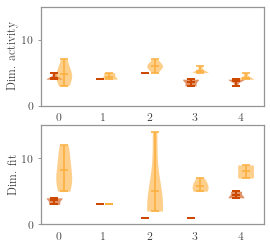

In [4]:
# Number of PCs necessary to reach 95 R^2
def plot_dims(axes):
    n_rows, n_cols = axes.shape
    
    # Load data
    with_noise = False
    if with_noise:
        file_name = "neuro_regress_output.pkl"
    else:
        file_name = "neuro_regress_output_no_noise.pkl"
    data_file = os.path.join(data_path, file_name)
    with open(data_file, 'rb') as handle:
        [
        task_names, task_lbls, n_task, lbl_sce,
        n_samples, n_sce, n_mi, dim_hid, bs_train_all,
        n_comp_max, n_comps, n_nc, frac_train, alpha_range, 
        loss, loss_fit, loss_test, r_sq, r_sq_test, alphas, 
        input_all, target_all, mask_all, ts_all, output_all, output_fit_all, 
        cevr_fit,
        ] = pickle.load(handle)
    print('Loaded from ', data_file)
    
    
    r2_thr = 0.9
    for i_r, i_c in np.ndindex(n_rows, n_cols):
        ax = axes[i_r, i_c]
        i_y = i_r
        if i_y == 1:
            # Fitting dimension
            n_comp_thr = n_comps[np.argmax(r_sq_test > r2_thr, axis=-1)]
            n_comp_thr = np.where(np.any(r_sq_test > r2_thr, axis=-1), n_comp_thr, np.nan)
            ys = n_comp_thr
        else:
            # PCA dimension
            ys = n_comps[np.argmax(cevr_fit > r2_thr, axis=-1)]
            ys = np.where(np.any(cevr_fit > r2_thr, axis=-1), ys, np.nan)
        plot_stats(ax, ys, sce_plt)
        for i_wo, i_sce in enumerate([2, 0]):
            # lbl = r"$\mathbf{w}_\mathrm{out}$ " + ["large", r"small"][i_wo]
            lbl = ["Aligned", "Oblique"][i_wo]
            ax.bar(0, 0, lw=0, color=cs_sce[i_sce], alpha=alpha_sce[i_sce], label=lbl)
        for i_g in range(2):
            c = ['0.7', '0.3'][i_g]
            lbl = "init. " + ["decaying", "chaotic"][i_g]
            alpha = [0.7, 1.][i_g]
            ax.bar(0, 0, lw=0, color=c, alpha=alpha, label=lbl)
        ax.set_ylim(0, 15)
        ax.set_yticks([0, 10])
        # lbl = r"$D_{%s,\, %d}$" % (["x", "\mathrm{fit}"][i_y], r2_thr*100)
        lbl = [r"Dim. activity", r"Dim. fit"][i_r]
        ax.set_ylabel(lbl)

n_rows = 2
n_cols = 1
fig = plt.figure(figsize=(4 * n_cols, 2. * n_rows))
axes_dims = subplots(fig, n_rows, n_cols)
plot_dims(axes_dims)

Loaded from  ../../data/oblique/neuro_perturb.pkl


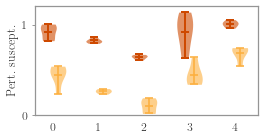

In [5]:
# Perturbation
def plot_suscept(ax):
    file_name = "neuro_perturb.pkl"
    data_file = os.path.join(data_path, file_name)
    with open(data_file, 'rb') as handle:
        [
        task_names, task_lbls, n_task, lbl_sce,
        n_samples, n_sce, n_mi, dim_hid, 
        pert_dirs, pert_dir_lbls, n_pd, n_pa, pert_amp_maxs, t_pert_mins, dt_pert_intvls, dt_pert_loss, n_pt, n_mip, 
        batch_size_pert, 
        n_comp_pert, resp_lbls, n_resp, 
        loss_pre_task, loss_pert_task, 
        output_pre_task, output_pert_task, 
        noise_hid_std_ex, task_pert_task, t_perts_task,
        wo_proj_pw_task, h_pre_proj_pw_task, h_pert_proj_pw_task,
        ] = pickle.load(handle)
    print('Loaded from ', data_file)

    # Relative susceptibility
    aucs = loss_pert_task.mean(-1).sum(-1)
    rel_auc_wout_pca = aucs[..., 0] / aucs[..., 1]
    
    ys = rel_auc_wout_pca
    plot_stats(ax, ys, sce_plt)
    ax.set_ylim(0, 1.2)
    ax.set_yticks([0, 1])
    # ax.set_ylabel(r"Suscept. out$\,/\,$PC", loc='bottom')
    ax.set_ylabel(r"Pert. suscept.")
    
n_rows = 1
n_cols = 1
fig = plt.figure(figsize=(4 * n_cols, 2. * n_rows))
ax_pert = subplots(fig, n_rows, n_cols)[0, 0]
plot_suscept(ax_pert)

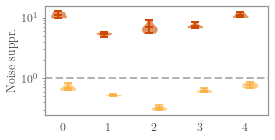

In [6]:

# Plot ratio var along output / var along PC
def plot_ratio_var(ax):
    file_name = "neuro_noise_compression.pkl"
    data_file = os.path.join(data_path, file_name)
    with open(data_file, 'rb') as handle:
        res = pickle.load(handle)
        [
        task_names, task_lbls, n_task, lbl_sce, dim_hid,
        n_samples, n_sce, n_mi, 
        n_tc, n_samp_per_tc,batch_size_ex, n_comp_tca, n_rps, n_ops, n_pps, var_rps, var_ops, var_pps, 
        ] = res
        del res

    # Ratio output var / random var
    ys = var_ops.mean(-1) / var_rps.mean(-1)
    plot_stats(ax, ys, sce_plt)
    
    ax.axhline(1, ls='--', c=c_leg)
    ax.set_yscale('log')
    
    # ax.set_ylabel("Var. output$\,/\,$random")
    ax.set_ylabel("Noise suppr.")
    
n_rows = 1
n_cols = 1
fig = plt.figure(figsize=(4 * n_cols, 2. * n_rows))
ax_ratio_var = subplots(fig, n_rows, n_cols)[0, 0]
plot_ratio_var(ax_ratio_var)


Loaded from  ../../data/oblique/neuro_corr.pkl


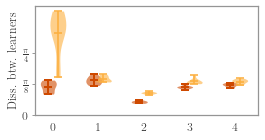

In [7]:

def plot_diss(ax):
    # Load reduced data for plotting
    with_noise = True
    if with_noise:
        file_name = "neuro_corr.pkl"
    else:
        file_name = "neuro_corr_no_noise.pkl"
    data_file = os.path.join(data_path, file_name)
    with open(data_file, 'rb') as handle:
        [
        task_names, task_lbls, n_task, lbl_sce,
        n_samples, n_sce, n_mi, dim_hid, 
        with_noise, loss_sce, n_steps_sce, norm_w_sce, norm_h_sce, corr_w_h_sce, 
        corr2_w_h_sce, crit_noise_std_sce, lin_dim_pr_sce, lin_dim_pca_sce, eff_ranks_sce, 
        lr0s_sce, alpha, dist_eucl_sce, dist_ang_sce, svs_cca_sce, 
            dist_eucl_ex_sce, dist_ang_ex_sce, 
        ] = pickle.load(handle)
    print('Loaded from ', data_file)
        
    ys = np.array(dist_ang_sce)
    plot_stats(ax, ys, sce_plt)
    # ax.set_ylabel("Dissimilarity")
    ax.set_ylabel("Diss. btw. learners")
    ymax = np.pi/4
    if ymax == np.pi/2:
        ax.set_yticks([0, np.pi/4, np.pi/2])
        ax.set_yticklabels([0, r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"])
        ax.set_ylim([0, np.pi/2])
    else:
        ax.set_yticks([0, np.pi/8, np.pi/4])
        ax.set_yticklabels([0, r"$\frac{\pi}{8}$", r"$\frac{\pi}{4}$"])
        ax.set_ylim([0, None])

n_rows = 1
n_cols = 1
fig = plt.figure(figsize=(4 * n_cols, 2. * n_rows))
ax_diss = subplots(fig, n_rows, n_cols)[0, 0]
plot_diss(ax_diss)


Loaded from  ../../data/oblique/neuro_corr_no_noise.pkl
Loaded from  ../../data/oblique/neuro_corr.pkl
Loaded from  ../../data/oblique/neuro_regress_output_no_noise.pkl
Loaded from  ../../data/oblique/neuro_perturb.pkl
Save figure to ../../tex/oblique/figures/neuro_all_init.both


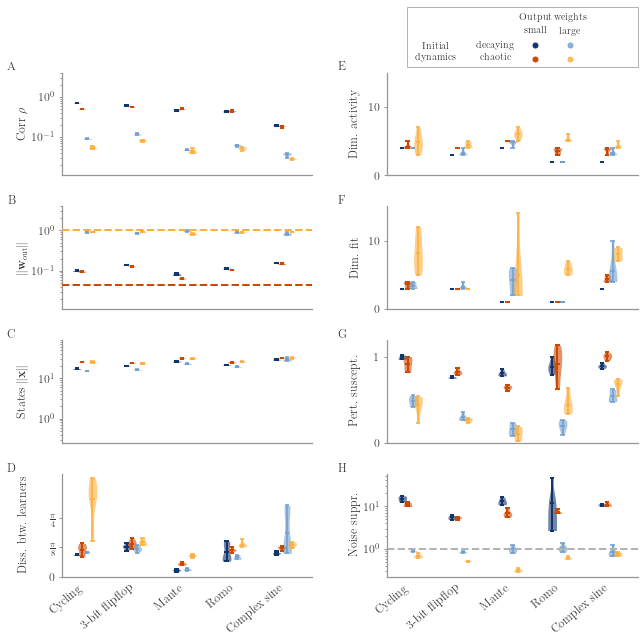

In [10]:
# Join all plots

# sce_plt = [3, 1]
sce_plt = [2, 3, 0, 1]
n_sce_plt = len(sce_plt)

fig = plt.figure(figsize=(8, 7), facecolor='w')

# Correlation, norms
n_rows = 4
n_cols = 2
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0., right=1., bottom=0., top=1., wspace=0.3, hspace=0.3)
axes = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_cols)] for k in range(n_rows)])
task_lbls = plot_corr(axes[:3, :1])
plot_diss(axes[3, 0])
plot_dims(axes[:2, 1:])
plot_suscept(axes[2, 1])
plot_ratio_var(axes[3, 1])

n_task = len(task_lbls)
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes[i_r, i_c]
    ax.set_xticks(np.arange(n_task))
    if i_r == n_rows - 1:
        ax.set_xticklabels(task_lbls, rotation=40, ha="right")
    else:
        ax.set_xticklabels([])
    style.fixticks(ax, manage_ticks=False)
for i_c in range(n_cols):
    fig.align_ylabels(axes[:, i_c])
    
    
########################################################################
# Legend by hand
ax = axes[0, 1]
# Create a Rectangle patch
if n_task == 5:
    x0_rec = 0.6
    dx_rec= 0.4
    x0 = 2.5
    dx = 0.7
    dxp = -0.8
    dxpp = -2.
else:
    x0_rec = 0.6
    dx_rec= 0.4
    x0 = 2.5
    dx = 0.7
    dxp = -0.8
    dxpp = -2.
y0_rec = 1.01
dy_rec = 0.12
y0 = 17
dy = 2
dyp = 2
dypp = 2
x1 = x0 + dx
y1 = y0 + dy
xis = [x0, x0, x1, x1]
yis = [y0, y1, y0, y1]
ypos = y1 + dyp
rect = plt.Rectangle((x0_rec, y0_rec), dx_rec, dy_rec,
    fill=False, color=c_leg, 
    transform=fig.transFigure, figure=fig)
fig.patches.extend([rect])
# Points
for i, j in np.ndindex(2, 2):
    k = 2*i + j
    x = xis[k]
    y = yis[k]
    j_c = (j+1) % 2
    i_sce = [3, 2, 1, 0][k]
    ax.plot(x, y, 'o', ms=5, c=cs_sce[i_sce], alpha=alpha_sce[i_sce], clip_on=False)
# Text
ax.text(x0, ypos, r"small", va='center', ha='center')#, transform=ax.transAxes)
ax.text(x1, ypos, r"large", va='center', ha='center')#, transform=ax.transAxes)
ax.text((x0+x1)/2, ypos+dypp, "Output weights", va='center', ha='center')#, transform=ax.transAxes)
ax.text(x0+dxp, y1, "decaying", va='center', ha='center')#, transform=ax.transAxes)
ax.text(x0+dxp, y0, "chaotic", va='center', ha='center')#, transform=ax.transAxes)
ax.text(x0+dxpp, (y0+y1)/2, "Initial\ndynamics", va='center', ha='center')#, transform=ax.transAxes)


# Label plots
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes[i_r, i_c]
    i = i_r + i_c * n_rows
    xpos = [-0.20, -0.18][i_c]
    ypos = 1.
    ax.text(xpos, ypos, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)

# Save figure
fig_name = "neuro_all_init"
# style.saving_fig(fig, figure_path, fig_name, data_type='both')